# Tensor flow and keras model

In [ ]:

#!rm - rf ./logs/
# install packages - Make sure to add data to colab!!!
%reload_ext tensorboard
!pip install tensorflow_addons
!pip install keras_tuner
!pip install typeguard==2.13.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:


# Load packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from tensorflow.keras.metrics import MeanAbsoluteError
import datetime
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Sumamary file
log_folder = 'logs'

# Import data and split into test and train
df_unprocessed = pd.read_csv('dataset_clean_18k.csv')
df = df_unprocessed.drop(['Std_dev', 'WaterDensity'], axis=1)
df['vmvf'] = (df['Pitch'] * df['Pitch'] / (np.pi * df['FuelRadius'] * df['FuelRadius'])) - 1 - (0.12 / df['FuelRadius']) - (0.0036 / (df['FuelRadius'] * df['FuelRadius']))
df

,Enrichment,FuelTemperature,WaterTemperature,Pitch,FuelRadius,Keff,vmvf
0,1.33,1500.0,429.4,1.989,0.639,1.13121,1.887416
1,7.50,1022.8,440.1,1.939,0.741,1.44104,1.011063
2,5.14,353.4,348.9,1.384,0.581,1.29719,0.589012
3,7.54,717.7,330.9,1.642,0.519,1.56388,1.941538
4,1.68,1166.0,407.4,1.008,0.204,1.05865,6.096867
...,...,...,...,...,...,...,...
18081,5.56,488.4,339.8,1.065,0.325,1.51146,2.014770
18082,5.48,1602.6,580.8,1.669,0.749,1.10691,0.413886
18083,7.23,1656.6,501.7,1.330,0.449,1.45195,1.507817
18084,6.96,1038.0,369.3,1.172,0.511,1.21955,0.425796


In [ ]:
# Pop Keff (prediting value)
features = df.drop(['Keff'], axis=1)
labels = df['Keff']

train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

# Getting features and labels

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Keff')
test_labels = test_features.pop('Keff')

train_dataset.describe().transpose()[['mean', 'std']]


# Normalise data
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [ ]:
# function to build mode
def model_builder(hp):

  # Different units and activation functions
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_activation = hp.Choice('activation', ['relu', 'tanh', 'logistic','selu'])
  model = keras.Sequential()
  model.add(normalizer)

  # 5 layers varying from 32-512 neurons
  for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='hp_activation'))
  model.add(keras.layers.Dense(1))

  # Different learning rates
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Compiling model
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=['MeanAbsoluteError'])

  return model



In [ ]:
# Loss plotter
def plot_loss(history):
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

In [ ]:
#plot_loss(history)

# Keras tuner

In [ ]:
# Build tuner with Hyperband
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_trials=10,
                     overwrite=True,
                     directory='/tmp/tb',
                     max_consecutive_failed_trials = 10)


# Search for parameters

tuner.search(train_features, train_labels, epochs=2, validation_split=0.2, callbacks=[keras.callbacks.TensorBoard('/tmp/tb_logs')])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]




In [ ]:
#Print summary of top 10
tuner.results_summary()

Results summary
Results in /tmp/tb/untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 08 summary
Hyperparameters:
units: 128
num_layers: 4
units_0: 160
learning_rate: 0.001
units_1: 320
units_2: 128
units_3: 96
Score: 0.015822583809494972

Trial 05 summary
Hyperparameters:
units: 512
num_layers: 1
units_0: 256
learning_rate: 0.001
units_1: 224
units_2: 160
units_3: 32
Score: 0.01996399089694023

Trial 01 summary
Hyperparameters:
units: 352
num_layers: 3
units_0: 192
learning_rate: 0.001
units_1: 32
units_2: 32
Score: 0.020367728546261787

Trial 07 summary
Hyperparameters:
units: 64
num_layers: 3
units_0: 192
learning_rate: 0.001
units_1: 288
units_2: 32
units_3: 128
Score: 0.020732246339321136

Trial 06 summary
Hyperparameters:
units: 192
num_layers: 1
units_0: 256
learning_rate: 0.001
units_1: 448
units_2: 64
units_3: 256
Score: 0.020841768011450768

Trial 09 summary
Hyperparameters:
units: 192
num_layers: 1
units_0: 320
learning_rate: 0.01
unit

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=100,
  decay_rate=1,
  staircase=False)

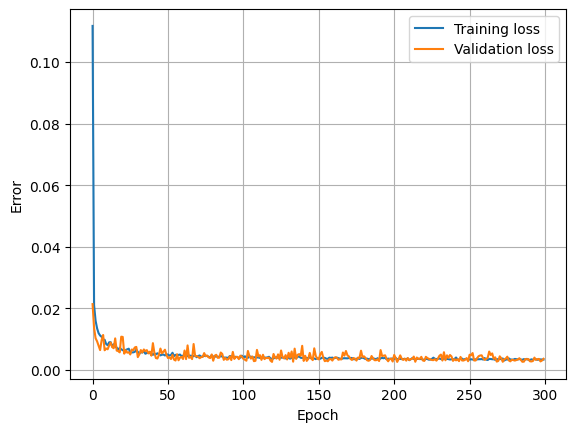

In [ ]:
#Shows loss across epochs
plot_loss(history)

In [ ]:
# Create model - update these parameters to reflect the optimal ones
model = keras.Sequential()
model.add(normalizer)
model.add(keras.layers.Dense(units=192, activation='relu'))
model.add(keras.layers.Dense(units=224, activation='relu'))
model.add(keras.layers.Dense(units=32, activation='relu'))
model.add(keras.layers.Dense(units=224, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=['MeanAbsoluteError'])

# Stores data from model

history = model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=300)

In [ ]:
# Dont run for now - only if want to use tensor board
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [ ]:
# Give MAE
test_results = model.evaluate(test_features, test_labels, verbose=0, callbacks=[keras.callbacks.TensorBoard('/tmp/tb_logs2')] )
print(f'Mean absolute error = {test_results}')

predicted_output = model.predict(test_features)

Mean absolute error = 0.0028948774561285973
114/114 [==============================] - 0s 2ms/step


In [ ]:
# Give r^2 value as well as other statistical parametrs

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, max_error
y_true = np.array(test_labels, dtype=np.float32)
values = []
for i in predicted_output:
  values.append(i[0])

y_pred = np.array(values, dtype=np.float32)
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_true, y_pred)
result = metric.result()

test_set_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
test_mae = mean_absolute_error(y_true, y_pred)

print(f'r^2 = {result}')
print(f'RMSE = {test_set_rmse}')
print(f'MAE = {test_mae}')
print(f'MAE PERCENTAGE = {mean_absolute_percentage_error(y_true, y_pred)*100000}')
print(f'MAX ERROR = {max_error(y_true, y_pred)*100000}')


r^2 = 0.9992636442184448
RMSE = 0.004672503098845482
MAE = 0.0028948793187737465
MAE PERCENTAGE = 241.49036034941673
MAX ERROR = 3874.8204708099365


In [ ]:
#predicting for all data points
#look at describing etc
y_predict = model.predict(features.values).flatten()
print(y_predict)

df["deltaKabs"] = np.abs(df["Keff"]-y_predict) * 100000
df["deltaKabs"] = df["deltaKabs"].round()
df['deltaKrel'] = np.abs((y_predict - df['Keff'])/df['Keff']) * 100000
df["deltaKrel"] = df["deltaKrel"].round()
df

566/566 [==============================] - 1s 2ms/step
[1.137 1.44  1.298 ... 1.451 1.216 1.403]


,Enrichment,FuelTemperature,WaterTemperature,Pitch,FuelRadius,Keff,vmvf,deltaKabs,deltaKrel
0,1.33,1500.0,429.4,1.989,0.639,1.13121,1.887416,620.0,548.0
1,7.50,1022.8,440.1,1.939,0.741,1.44104,1.011063,106.0,73.0
2,5.14,353.4,348.9,1.384,0.581,1.29719,0.589012,44.0,34.0
3,7.54,717.7,330.9,1.642,0.519,1.56388,1.941538,92.0,59.0
4,1.68,1166.0,407.4,1.008,0.204,1.05865,6.096867,171.0,161.0
...,...,...,...,...,...,...,...,...,...
18081,5.56,488.4,339.8,1.065,0.325,1.51146,2.014770,68.0,45.0
18082,5.48,1602.6,580.8,1.669,0.749,1.10691,0.413886,192.0,174.0
18083,7.23,1656.6,501.7,1.330,0.449,1.45195,1.507817,68.0,47.0
18084,6.96,1038.0,369.3,1.172,0.511,1.21955,0.425796,312.0,256.0


Text(0.5, 0, 'pcm relative error on Keff predictions')

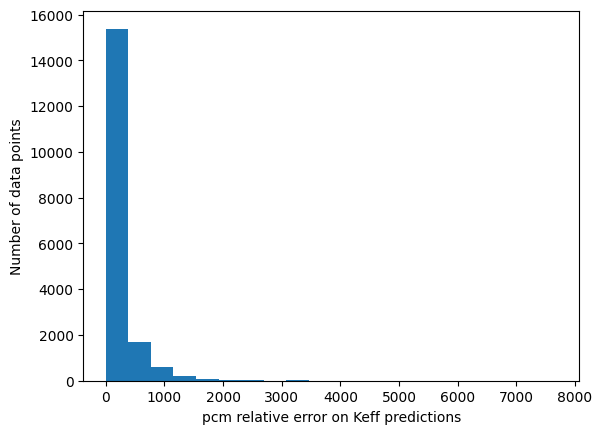

In [ ]:
# Histogram for relative error

plt.hist(df["deltaKrel"], bins=20)
plt.ylabel('Number of data points')
plt.xlabel('pcm relative error on Keff predictions')


In [ ]:
# A table for high error values
df_high_error = df[df["deltaKabs"] > 3000]
df_high_error

,Enrichment,FuelTemperature,WaterTemperature,Pitch,FuelRadius,Keff,vmvf,deltaKabs,deltaKrel
633,1.15,1642.7,594.5,1.062,0.376,0.99220,1.194742,3062.0,3086.0
4037,1.15,1264.5,567.6,1.455,0.309,0.97882,5.631581,3875.0,3959.0
6380,1.05,1778.1,552.3,1.005,0.279,1.01184,2.653871,3161.0,3124.0
6738,1.05,1415.7,581.8,1.628,0.338,0.93652,5.998034,4239.0,4527.0
9960,1.27,738.9,591.9,1.639,0.313,0.98075,7.307960,3208.0,3271.0
10666,1.15,1070.7,572.3,1.869,0.466,1.05921,3.846229,3435.0,3243.0
15368,1.14,687.6,330.5,1.615,0.221,0.56856,15.381806,4372.0,7689.0


Text(0.5, 0, 'Keff')

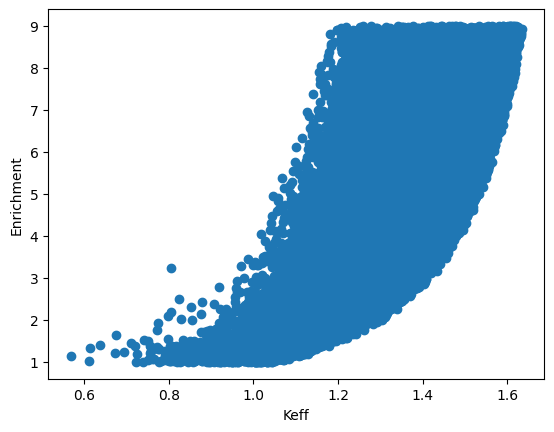

In [ ]:
# Enrichment vs Keff plots
plt.scatter(df['Keff'], df['Enrichment'])
plt.ylabel('Enrichment')
plt.xlabel('Keff')

In [ ]:
df.describe(percentiles=[0.9, 0.95, 0.99])

,Enrichment,FuelTemperature,WaterTemperature,Pitch,FuelRadius,Keff,vmvf,deltaKabs,deltaKrel
count,18086.000000,18086.000000,18086.000000,18086.000000,18086.000000,18086.000000,18086.000000,18086.000000,18086.000000
mean,4.990335,1122.321619,444.603749,1.497257,0.472838,1.354016,2.744388,267.055734,220.439511
std,2.300221,394.176216,86.525826,0.291036,0.153357,0.171434,2.649116,324.207385,321.430665
min,1.000000,303.000000,300.000000,1.000000,0.200000,0.568560,0.342911,0.000000,0.000000
50%,4.980000,1125.450000,441.600000,1.496000,0.449000,1.377630,1.824023,163.000000,117.000000
90%,8.190000,1663.950000,567.300000,1.902000,0.698000,1.559590,6.297084,625.500000,528.000000
95%,8.570000,1730.375000,584.000000,1.951000,0.762000,1.583798,8.173267,908.750000,814.000000
99%,8.900000,1785.200000,596.600000,1.991000,0.851000,1.610604,12.216042,1552.800000,1568.000000
max,9.000000,1799.900000,599.900000,2.000000,0.899000,1.633880,26.279957,4372.000000,7689.000000


In [ ]:
# K fold cross validation with SKlearn packages - 10 folds
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, max_error

k_fold = 10

X= train_features.values
y = train_labels.values

kf =KFold(n_splits=k_fold)
mse_scores = []

for train_index, val_index in kf.split(train_features):
  X_train, y_train = X[train_index], y[train_index]
  X_val, y_val = X[val_index], y[val_index]

  model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=['MeanAbsoluteError'])

  scores = model.evaluate(X_val, y_val, verbose=0)
  mse_scores.append(scores)

print(mse_scores)
avg_score = np.mean(mse_scores)
print(avg_score)

[0.0024166672956198454, 0.0027108537033200264, 0.002591628348454833, 0.0024633905850350857, 0.0025421949103474617, 0.0025363315362483263, 0.002538626082241535, 0.0026664442848414183, 0.0028624695260077715, 0.002816143212839961]
0.0026144749484956265


In [ ]:
# Testing on new data

simtimeunprocesseddf = pd.read_csv('feed_to_model.csv')

# Process data in same way (needs to have same shape as model input data)

simdf = simtimeunprocesseddf.drop(['WaterDensity'], axis=1)
simdf['vmvf'] = (simdf['Pitch'] * simdf['Pitch'] / (np.pi * simdf['FuelRadius'] * simdf['FuelRadius'])) - 1 - (0.12 / simdf['FuelRadius']) - (0.0036 / (simdf['FuelRadius'] * simdf['FuelRadius']))
#simdf
features = simdf.drop(['Keff'], axis=1)
labels = simdf['Keff']

predicted_vals = model.predict(features.values)

test_results = model.evaluate(features.values, labels.values, verbose=0)
print(f'Mean absolute error = {test_results}')

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, max_error
y_true = np.array(labels, dtype=np.float32)
values = []
for i in predicted_vals:
  values.append(i[0])

y_pred = np.array(values, dtype=np.float32)
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_true, y_pred)
result = metric.result()

test_set_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
test_mae = mean_absolute_error(y_true, y_pred)

# Gives same parameters as before for comparison

print(f'r^2 = {result}')
print(f'RMSE = {test_set_rmse}')
print(f'MAE = {test_mae}')
print(f'MAE PERCENTAGE = {mean_absolute_percentage_error(y_true, y_pred)*100000}')
print(f'MAX ERROR = {max_error(y_true, y_pred)*100000}')

simdf["deltaKabs"] = np.abs(simdf["Keff"]-y_pred) * 100000
simdf["deltaKabs"] = simdf["deltaKabs"].round()
simdf['deltaKrel'] = np.abs((y_pred - simdf['Keff'])/simdf['Keff']) * 100000
simdf["deltaKrel"] = simdf["deltaKrel"].round()
simdf.describe(percentiles=[0.9, 0.95, 0.99])


1/1 [==============================] - 0s 35ms/step
Mean absolute error = 0.005511087365448475
r^2 = 0.9984855651855469
RMSE = 0.00846361555159092
MAE = 0.005511079449206591
MAE PERCENTAGE = 528.4470040351152
MAX ERROR = 3151.249885559082


,Enrichment,FuelTemperature,WaterTemperature,Pitch,FuelRadius,Keff,vmvf,deltaKabs,deltaKrel
count,30.000000,30.000000,30.000000,30.000000,3.000000e+01,30.000000,30.000000,30.000000,30.000000
mean,4.466667,1153.500000,471.400000,1.466667,4.000000e-01,1.236834,3.452148,551.133333,528.466667
std,2.596195,420.126315,92.159756,0.507416,1.129203e-16,0.221204,3.028418,653.366757,791.116528
min,1.000000,307.000000,301.000000,1.000000,4.000000e-01,0.815099,0.666937,42.000000,33.000000
50%,4.000000,1248.000000,488.000000,1.000000,4.000000e-01,1.238073,0.666937,373.000000,307.500000
90%,8.000000,1639.700000,571.000000,2.000000,4.000000e-01,1.558222,6.635247,998.200000,1048.800000
95%,8.000000,1739.750000,582.750000,2.000000,4.000000e-01,1.562249,6.635247,1759.100000,2073.450000
99%,8.710000,1794.810000,590.680000,2.000000,4.000000e-01,1.569083,6.635247,2891.160000,3420.620000
max,9.000000,1798.000000,593.000000,2.000000,4.000000e-01,1.571176,6.635247,3151.000000,3688.000000


1/1 [==============================] - 0s 108ms/step
Mean absolute error = 0.04789944365620613
r^2 = 0.4699666500091553
RMSE = 0.12213031947612762
MAE = 0.04789943993091583
MAE PERCENTAGE = 3944.2505687475204
MAX ERROR = 40707.433223724365


,Enrichment,FuelTemperature,WaterTemperature,Pitch,FuelRadius,Keff,vmvf,deltaKabs,deltaKrel
count,30.000000,30.000000,30.000000,30.000000,3.000000e+01,30.000000,30.000000,30.000000,30.000000
mean,11.866667,1248.300000,538.766667,2.433333,9.000000e-01,1.397077,1.285569,4789.900000,3944.266667
std,2.161311,475.296071,85.497604,0.504007,2.258405e-16,0.170621,0.990311,11426.596924,9642.284534
min,9.000000,542.000000,408.000000,2.000000,9.000000e-01,1.109319,0.434123,76.000000,54.000000
50%,12.000000,1290.000000,550.500000,2.000000,9.000000e-01,1.328836,0.434123,767.000000,602.000000
90%,15.000000,1878.000000,645.900000,3.000000,9.000000e-01,1.619013,2.398999,10740.200000,9331.300000
95%,15.000000,1906.800000,660.600000,3.000000,9.000000e-01,1.640322,2.398999,37051.800000,30467.600000
99%,15.000000,1938.620000,673.100000,3.000000,9.000000e-01,1.646722,2.398999,40181.520000,34609.850000
max,15.000000,1945.000000,676.000000,3.000000,9.000000e-01,1.647004,2.398999,40707.000000,35432.000000


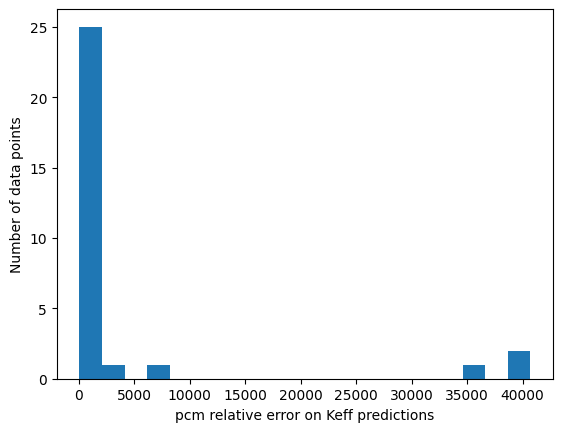

In [ ]:
# Testing on data outside range

# See explanation above (same code)

outerrangedf_unprocessed = pd.read_csv('outside_range_model.csv')

ordf = outerrangedf_unprocessed.drop(['WaterDensity'], axis=1)
ordf['vmvf'] = (ordf['Pitch'] * ordf['Pitch'] / (np.pi * ordf['FuelRadius'] * ordf['FuelRadius'])) - 1 - (0.12 / ordf['FuelRadius']) - (0.0036 / (ordf['FuelRadius'] * ordf['FuelRadius']))
#simdf
features = ordf.drop(['Keff'], axis=1)
labels = ordf['Keff']

predicted_vals = model.predict(features.values)

test_results = model.evaluate(features.values, labels.values, verbose=0)
print(f'Mean absolute error = {test_results}')

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, max_error
y_true = np.array(labels, dtype=np.float32)
values = []
for i in predicted_vals:
  values.append(i[0])

y_pred = np.array(values, dtype=np.float32)
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_true, y_pred)
result = metric.result()

test_set_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
test_mae = mean_absolute_error(y_true, y_pred)

print(f'r^2 = {result}')
print(f'RMSE = {test_set_rmse}')
print(f'MAE = {test_mae}')
print(f'MAE PERCENTAGE = {mean_absolute_percentage_error(y_true, y_pred)*100000}')
print(f'MAX ERROR = {max_error(y_true, y_pred)*100000}')



ordf["deltaKabs"] = np.abs(ordf["Keff"]-y_pred) * 100000
ordf["deltaKabs"] = ordf["deltaKabs"].round()
ordf['deltaKrel'] = np.abs((y_pred - ordf['Keff'])/ordf['Keff']) * 100000
ordf["deltaKrel"] = ordf["deltaKrel"].round()
ordf

plt.hist(ordf["deltaKabs"], bins=20)
plt.ylabel('Number of data points')
plt.xlabel('pcm relative error on Keff predictions')

df_high_error = ordf[ordf["deltaKrel"] > 5000]

ordf.describe(percentiles=[0.9, 0.95, 0.99])


In [ ]:
# Code to define model architecture
def diffusion_PINN():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(20, activation='tanh', input_shape=(1,))
    ])

    # Number of hidden layers
    for i in range(4):
        model.add(tf.keras.layers.Dense(64, activation='tanh'))

    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='linear', name='output_layer'))

    return model